In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle

### Loading Data

In [ ]:
news = pd.read_csv(r"/content/drive/My Drive/telugu - telugu.csv")

In [ ]:
news.head()

,text,summary
0,ప్రమాదకర కరోనా వైరస్‌ భారత ఆర్మీకి సైతం పాకింద...,ఆర్మీ జవాన్‌కు కరోనా పాజిటివ్‌
1,సంక్షోభంలో పడిన ప్రైవేటు బ్యాంకు యస్‌ బ్యాంకు...,"యస్‌’ పునర్నిర్మాణ పథకం, త్వరలోనే ఆంక్షలు ఎత్త..."
2,ఏపీలో స్థానిక సంస్థల ఎన్నికలు వాయిదా వేయడాన్ని...,చంద్రబాబు క్షమాపణ చెప్పాలి
3,పాకిస్తాన్‌ మాజీ క్రికెటర్‌ షోయబ్‌ అక్తర్‌ చైన...,‘ఏది పడితే అది తిని ఈ మహమ్మారిని తెచ్చారు’
4,రాష్ట వ్యాప్తంగా సంచలన సృష్టించిన మిర్యాలగూడ ప...,తల్లి గిరిజను కలిసిన అమృతా ప్రణయ్‌


In [ ]:
news.shape

(1007, 2)

In [ ]:
document = news['text']
summary = news['summary']

In [ ]:
document[30], summary[30]

('ప్రపంచమార్కెట్లలో కరోనా ప్రళయం కొనసాగుతూనే ఉంది. మహా పతనాల బాటలో స్టాక్\u200cమార్కెట్లు శుక్రవారం కూడా మరింత అధఃపాతాళానికి పడిపోయాయి. భారత్\u200cలో తొలి కరోనా మరణం నమోదు కావడంతో మార్కెట్\u200c మరోమారు అత్యంత ఘోరంగా కుప్పకూలింది. అయితే, అంతేవేగంతో నేలక్కొట్టిన బంతిలా మార్కెట్\u200c దూసుకెళ్లి ఇన్వెస్టర్లకు అసలుసిసలు రోలర్\u200c కోస్టర్\u200c రైడ్\u200cను చూపించింది. గడిచిన 12 ఏళ్లలో ఎన్నడూ జరగని రీతిలో తొలిసారి మన స్టాక్\u200c మార్కెట్లో మళ్లీ ట్రేడింగ్\u200c నిలిపేయాల్సిన పరిస్థితి తలెత్తింది.ఒకానొక దశలో సెన్సెక్స్\u200c 3,389 పాయింట్లు నష్టపోయి... ఆ కనిష్ట స్థాయి నుంచి 5,380 పాయింట్లు దూసుకెళ్లడం తీవ్రమైన ఒడిదుడుకులకు నిదర్శనం. చివరకు 1,325 పాయింట్లు లాభపడి 34,103 వద్ద ముగిసింది. ఒకేరోజు ఇంత ఘోరంగా పడిపోవడం, మళ్లీ ఈస్థాయిలో రికవరీ.. ఈ రెండూ కూడా కొత్త రికార్డులే కావడం గమనార్హం. కాగా, శుక్రవారం ఆరంభంలో 15 నిమిషాల్లోనే రూ.12.9 లక్షల కోట్ల ఇన్వెస్టర్ల సంపద తుడిచిపెట్టుకుపోగా... చివరికి ఈ నష్టాలన్నింటినీ పూడ్చుకోవడంతోపాటు రూ.3.5 లక్షల కోట్ల మార్కెట్\u200c విలువ పెరగడం విశేషం!! ',
 '‘కోవ

### Preprocessing

In [ ]:
# for decoder sequence
summary = summary.apply(lambda x: '<go> ' + str(x) + ' <stop>')
summary.head()

0           <go> ఆర్మీ జవాన్‌కు కరోనా పాజిటివ్‌ <stop>
1    <go> యస్‌’ పునర్నిర్మాణ పథకం, త్వరలోనే ఆంక్షలు...
2               <go> చంద్రబాబు క్షమాపణ చెప్పాలి <stop>
3    <go> ‘ఏది పడితే అది తిని ఈ మహమ్మారిని తెచ్చారు...
4       <go> తల్లి గిరిజను కలిసిన అమృతా ప్రణయ్‌ <stop>
Name: summary, dtype: object

#### Tokenizing the texts into integer tokens

In [ ]:
# since < and > from default tokens cannot be removed
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

In [ ]:
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

In [ ]:
document_tokenizer.fit_on_texts(document)
summary_tokenizer.fit_on_texts(summary)

In [ ]:
inputs = document_tokenizer.texts_to_sequences(document)
targets = summary_tokenizer.texts_to_sequences(summary)

In [ ]:
summary_tokenizer.texts_to_sequences(["దేశంలో జరిగే అన్ని ఫుట్‌బాల్‌ మ్యాచ్‌లను ఈ నెల 31 వరకు రద్దు చేస్తూ అఖిల భారత ఫుట్‌బాల్‌ సమాఖ్య (ఏఐఎఫ్‌ఎఫ్‌) శనివారం నిర్ణయం తీసుకుంది. దాంతో ఐ–లీగ్, డివిజన్‌–2, యూత్‌ లీగ్, గోల్డెన్‌ లీగ్, జాతీయ టోర్నీలు రద్దయ్యాయి. ఐ–లీగ్‌లోని 28 మ్యాచ్‌లను ప్రేక్షకులు లేకుండానే నిర్వహించాలని ఏఐఎఫ్‌ఎఫ్‌ తొలుత అనుకున్నా... కేంద్ర ఆరోగ్య మంత్రిత్వ శాఖ సలహా మేరకు ఈ నెల చివరి వరకు దేశంలో ఎటువంటి ఫుట్‌బాల్‌ మ్యాచ్‌లను నిర్వహించరాదని  నిర్ణయించింది."])

[[656,
  1,
  2158,
  76,
  1,
  12,
  204,
  75,
  48,
  283,
  1,
  1,
  105,
  76,
  1,
  1,
  1,
  1573,
  1,
  1,
  1,
  1,
  387,
  1,
  1,
  1,
  467,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  286,
  1,
  1,
  954,
  1,
  1,
  12,
  204,
  968,
  48,
  656,
  1,
  76,
  1,
  1,
  1]]

In [ ]:
summary_tokenizer.sequences_to_texts([[184, 22, 12, 71]])

['ఘోర చంద్రబాబు ఈ రియల్టీ']

In [ ]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(25646, 2938)

#### Obtaining insights on lengths for defining maxlen

In [ ]:
document_lengths = pd.Series([len(x) for x in document])
summary_lengths = pd.Series([len(x) for x in summary])

In [ ]:
document_lengths.describe()

count    1007.000000
mean      634.841112
std       206.310924
min       208.000000
25%       478.500000
50%       618.000000
75%       747.000000
max      1805.000000
dtype: float64

In [ ]:
summary_lengths.describe()

count    1007.000000
mean       44.391261
std        13.294636
min        20.000000
25%        37.000000
50%        43.000000
75%        50.000000
max       203.000000
dtype: float64

In [ ]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 400
decoder_maxlen = 8

#### Padding/Truncating sequences for identical sequence lengths

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

### Creating dataset pipeline

In [ ]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

In [ ]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Positional Encoding for adding notion of position among words as unlike RNN this is non-directional

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


### Masking

- Padding mask for masking "pad" sequences
- Lookahead mask for masking future words from contributing in prediction of current words in self attention

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

### Building the Model

#### Scaled Dot Product

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-Headed Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

### Feed Forward Network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### Fundamental Unit of Transformer encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


#### Fundamental Unit of Transformer decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


#### Encoder consisting of multiple EncoderLayer(s)

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x


#### Decoder consisting of multiple DecoderLayer(s)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


#### Finally, the Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


### Training

In [ ]:
# hyper-params
num_layers = 4
d_model = 128
dff = 512
num_heads = 4
EPOCHS = 100

#### Adam optimizer with custom learning rate scheduling

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#### Defining losses and other metrics 

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

#### Transformer

In [ ]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=encoder_vocab_size, 
    pe_target=decoder_vocab_size,
)

#### Masks

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask


#### Checkpoints

In [ ]:
checkpoint_path = "/content/sample_data/checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#### Training steps

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [ ]:
los = []

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        # 55k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 55k / 64 ~ 858; 858 / 2 = 429
        #if batch % 429 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    if (epoch + 1) % 1:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    los.append(train_loss.result())

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 8.0477
Epoch 1 Batch 1 Loss 8.0374
Epoch 1 Batch 2 Loss 8.0363
Epoch 1 Batch 3 Loss 8.0388
Epoch 1 Batch 4 Loss 8.0427
Epoch 1 Batch 5 Loss 8.0436
Epoch 1 Batch 6 Loss 8.0416
Epoch 1 Batch 7 Loss 8.0423
Epoch 1 Batch 8 Loss 8.0410
Epoch 1 Batch 9 Loss 8.0381
Epoch 1 Batch 10 Loss 8.0370
Epoch 1 Batch 11 Loss 8.0362
Epoch 1 Batch 12 Loss 8.0355
Epoch 1 Batch 13 Loss 8.0332
Epoch 1 Batch 14 Loss 8.0299
Epoch 1 Batch 15 Loss 8.0290
Epoch 1 Loss 8.0290
Time taken for 1 epoch: 17.205416202545166 secs

Epoch 2 Batch 0 Loss 7.9843
Epoch 2 Batch 1 Loss 7.9735
Epoch 2 Batch 2 Loss 7.9661
Epoch 2 Batch 3 Loss 7.9693
Epoch 2 Batch 4 Loss 7.9689
Epoch 2 Batch 5 Loss 7.9665
Epoch 2 Batch 6 Loss 7.9623
Epoch 2 Batch 7 Loss 7.9575
Epoch 2 Batch 8 Loss 7.9548
Epoch 2 Batch 9 Loss 7.9504
Epoch 2 Batch 10 Loss 7.9473
Epoch 2 Batch 11 Loss 7.9437
Epoch 2 Batch 12 Loss 7.9399
Epoch 2 Batch 13 Loss 7.9354
Epoch 2 Batch 14 Loss 7.9323
Epoch 2 Batch 15 Loss 7.9277
Epoch 2 Loss 7.9277
Tim

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
epochs = list(range(1,101))

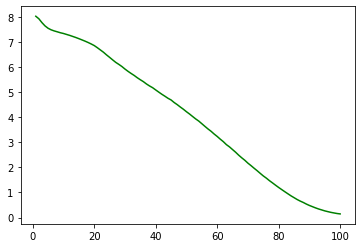

In [ ]:
plt.plot(epochs, los, 'g', label='Training-loss')

### Inference

#### Predicting one word at a time at the decoder and appending it to the output; then taking the complete sequence as an input to the decoder and repeating until maxlen or stop keyword appears

In [ ]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [ ]:
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [ ]:
summarize(
    "పాకిస్తాన్‌ మాజీ క్రికెటర్‌ షోయబ్‌ అక్తర్‌ చైనీయులపై మండిపడ్డారు. ఏది పడితే అది తిని ప్రపంచాన్ని ప్రమాదంలోకి నెట్టారని ఆగ్రహం వ్యక్తం చేశారు. అసలు గబ్బిలాలు, కుక్కలు, పాములు, పిల్లులు, ఎలుకల్ని ఎలా తింటారని విస్మయం వ్యక్తం చేశారు. వాటి రక్తం, వ్యర్థాలను సైతం ఆహారంగా తీసుకునే చైనీయులపై కోపం వస్తోందని అన్నారు. కరోనా వ్యాప్తితో ప్రపంచంలోని అన్ని దేశాలు తీవ్ర ఇబ్బందులు ఎదుర్కొంటున్నాయని పేర్కొన్నారు. పర్యాటకం దెబ్బతిందని, ఆర్థిక వ్యవస్థ క్షీణించిందని  తెలిపారు. కోవిడ్‌ ప్రభావం క్రీడలపైనా పడిందని తన యూట్యూబ్‌ చానెల్‌లో చెప్పుకొచ్చారు. "
)

'‘ఏది పడితే అది తిని ఈ మహమ్మారిని తెచ్చారు’'

In [ ]:
summarize("దేశంలో జరిగే అన్ని ఫుట్‌బాల్‌ మ్యాచ్‌లను ఈ నెల 31 వరకు రద్దు చేస్తూ అఖిల భారత ఫుట్‌బాల్‌ సమాఖ్య (ఏఐఎఫ్‌ఎఫ్‌) శనివారం నిర్ణయం తీసుకుంది. దాంతో ఐ–లీగ్, డివిజన్‌–2, యూత్‌ లీగ్, గోల్డెన్‌ లీగ్, జాతీయ టోర్నీలు రద్దయ్యాయి. ఐ–లీగ్‌లోని 28 మ్యాచ్‌లను ప్రేక్షకులు లేకుండానే నిర్వహించాలని ఏఐఎఫ్‌ఎఫ్‌ తొలుత అనుకున్నా... కేంద్ర ఆరోగ్య మంత్రిత్వ శాఖ సలహా మేరకు ఈ నెల చివరి వరకు దేశంలో ఎటువంటి ఫుట్‌బాల్‌ మ్యాచ్‌లను నిర్వహించరాదని  నిర్ణయించింది.")

'31 వరకు దేశంలో ‘నో’ ఫుట్\u200cబాల్\u200c'

In [ ]:
summarize("కరోనావైరస్‌ మహమ్మారి కట్టడి కోసం లాక్‌డౌన్‌ విధించిన నేపథ్యంలో దేశీ స్మార్ట్‌ఫోన్స్‌ పరిశ్రమ తీవ్రంగా నష్టపోనుంది. ఇది సుమారు 2 బిలియన్‌ డాలర్ల మేర ఉండొచ్చని కౌంటర్‌పాయింట్‌ రీసెర్చ్‌ సంస్థ అంచనా వేసింది. మార్చి, ఏప్రిల్‌లో విక్రయాలు గణనీయంగా మందగించడం ఇందుకు కారణంగా ఉంటుందని పేర్కొంది. మార్చి మధ్య దాకా కరోనా మహమ్మారి ప్రభావం ఒక మోస్తరుగానే ఉన్నప్పటికీ.. ఆ తర్వాత విజృంభిస్తుండటంతో లాక్‌డౌన్‌ అనివార్యమైందని వివరించింది.దీని ఫలితంగా 2020లో స్మార్ట్‌ఫోన్ల విక్రయం గతేడాది నమోదైన 15.8 కోట్లతో పోలిస్తే 3 శాతం తగ్గి 15.3 కోట్లకు పరిమితం కావొచ్చని అంచనా వేసింది. వార్షిక ప్రాతిపదికన చూస్తే మార్చిలో 27 శాతం తగ్గనుండగా, ఏప్రిల్‌ 14 దాకా లాక్‌డౌన్‌ కొనసాగితే ఈ నెలలో దాదాపు 60 శాతం తగ్గుదల నమోదు కావొచ్చని కౌంటర్‌పాయింట్‌ రీసెర్చ్‌ అసోసియేట్‌ డైరెక్టర్‌ తరుణ్‌ పాఠక్‌ తెలిపారు. కరోనా వైరస్‌ మహమ్మారికి మూలకేంద్రమైన చైనా నుంచి విడిభాగాల సరఫరా దెబ్బతినడం వల్ల ఈ ఏడాది తొలి త్రైమాసికంలో స్మార్ట్‌ఫోన్‌ తయారీ సంస్థలు తీవ్రంగా ఇబ్బందిపడ్డాయి.")

'నా శైలి అందరికీ తెలుసు'

In [ ]:
summarize("కోవిడ్‌–19 కేసులపై డిపార్ట్‌మెంట్‌లో ఎవరూ మాట్లాడవద్దని ముఖ్యంగా మీడియాతో అసలు చర్చించవద్దని డీజీపీ మహేందర్‌రెడ్డి ఆదేశాలు జారీ చేశారు. గత 50 రోజులుగా లాక్‌డౌన్‌ కారణంగా.. జనసంచారం లేకపోవడం, అంతా ఇళ్లకే పరిమితమవడంతో రాష్ట్రంలో నేరాలు గణనీయంగా తగ్గుముఖం పట్టాయి. మర్కజ్‌ లింకులు, ఇక్కడి నుంచి వలస కూలీలను పంపడం, రాష్ట్రానికి వచ్చిన వలస కూలీల గుర్తింపు వరకు పోలీసులు అన్నీ తామై వ్యవహరించారు. కేంద్ర– రాష్ట్ర ప్రభుత్వాలు లాక్‌డౌన్‌కు మెజారిటీ ప్రాంతాల్లో మినహాయింపులు ఇచ్చాయి. మరోవైపు నేరాలు, దోపిడీలు, రోడ్డు ప్రమాదాలు, హత్యలు, దొంగతనాల కేసులు కూడా పెరుగుతున్నాయి. ఇకపై కరోనాతోపాటు సాధారణ నేరాల నియంత్రణకు కృషి చేయాలని డీజీపీ ఆదేశించారు.")

"యాంకర్\u200c రవి 'తోటబావి' టీజర్\u200c విడుదల"

In [ ]:
summarize("అమెరికా అధ్యక్షుడు డొనాల్డ్‌ ట్రంప్‌ ఆడవారిపై అసభ్య వ్యాఖ్యలు చేసిన వీడియో అమెరికాలో కలకలం రేపింది. తరువాత అది నకిలీదని తేలింది. ఓ హాలీవుడ్‌ హీరోయిన్‌ పోర్న్‌ క్లిప్‌ ఇంటర్నెట్‌లో ప్రత్యక్షం.. అందులో ఉన్నది తాను కాదన్నా ఎవరూ నమ్మలేదు. కానీ, ఆమె చెప్పేది నిజమే. మనకు నచ్చిన సెలబ్రిటీల శరీరానికి సామాన్యుల ముఖాలను అంటించి మురిసిపోయే వీలున్న ఆర్టిఫిషియల్‌ ఇంటెలిజెన్స్‌ ఆధారంగా పనిచేసే ‘డీప్‌ఫేక్‌’సాఫ్ట్‌వేర్‌ సృష్టిస్తోన్న మాయాజాలమిది.ఈ యాప్‌ వచ్చిన కొత్తలో తమకు ఇష్టమైన హీరో, గాయకులు, రాజకీయ నాయకులను అనుకరిస్తూ.. పలు ఫొటోలు, వీడియోలు సృష్టించి, వాటిని సోషల్‌ మీడియా వేదికలపై పంచుకునేవారు. వాటికి వచ్చే లైకులు చూసి సంబరపడిపోయే వారు. అక్కడి వరకే పరిమితమైతే సరిపోయేది. కానీ, కొందరు మరో అడుగు ముందుకేసి.. సంచలనం సృష్టించాలని, తమ టీవీ చానళ్లకు రేటింగులను పెంచాలనే దురుద్దేశంతో డీప్‌ఫేక్‌ను వాడుకుని సెలబ్రిటీల ప్రతిష్టను దెబ్బతీసేలా తప్పుడు సందేశాలు, అసభ్య వీడియోలు సృష్టించి వాటిని వైరల్‌ చేస్తున్నారు. అవి నకిలీవని నిరూపించుకునేందుకు బాధితులు నానా తంటాలు పడుతున్నారు. ")

'సెలబ్రిటీల ఫేక్\u200c వీడియోలతో పోర్న్\u200c క్లిప్\u200cల తయారీ'

In [ ]:
summarize("టిక్ టాక్  యాప్ ను భారతీయులు అధికంగా వినియోగిస్తున్నారు. రోజురోజుకు టిక్ టాక్  యాప్ ను ఉపయోగిస్తున్నవారి సంఖ్య పెరుగుతోంది. యూజర్లు తమ వీడియోల ద్వారా ప్రతిభను బయటపెడుతున్నారు. అదేవిధంగా చాలా మంది ఈ టిక్ టాక్  వీడియోల్లో డాన్స్ లు, పాటలు, చాలెంజ్ లు చేస్తూ.. సోషల్ మీడియాలో పాపులర్  అయిన విషయం తెలిసిందే. సాధారణంగా ఈ టిక్ టాక్  వీడియోలను చూస్తూ.. వైరల్ గా మారిన వీడియోలను షేర్  చేస్తూ యూజర్లు గంటల కొద్ది సమయాన్ని గడిపేస్తున్నారు. కొంతమందికి తమ ప్రతిభను బయట పెట్టడానికి.. మరికొంతమందికి కాలక్షేపం, వినోదానికి అనువుగా ఉండటంలో ఈ యాప్ పై యూజర్లు బోలడంత సమయాన్ని కేటాయిస్తున్నారు.")

'భారతీయులు టిక్\u200cటాక్\u200cలో తెగ గడిపేశారు'

In [ ]:
summarize("సూర్యుడికి సంబంధించిన అత్యంత అరుదైన ఫొటోలను అమెరికా ఖగోళ శాస్త్రవేత్తలు విడుదల చేశారు. ప్రపంచంలోనే అత్యంత పెద్దదైన సోలార్ టెలిస్కోప్ గా ప్రసిద్ధి పొందిన డేనియల్ కే ఇనౌయే సోలార్ టెలిస్కోప్ (డీకేఐఎస్ టీ) అద్భుత ఆవిష్కారానికి కారణమైంది. దీని ద్వారా సూర్యుడి ఉపరితలానికి సంబంధించిన అరుదైన ఫొటోలను చూసే అవకాశం మానవాళికి దక్కింది. కాగా హవాయి ద్వీపంలో ఏర్పాటు చేసిన ఈ భారీ టెలిస్కోపు ద్వారా సూర్యుడిని అత్యంత సమీపంగా చూస్తూ.. అంతర్గత శక్తిని అంచనా వేసే అవకాశం ఉంటుందని ఆస్ట్రోనాట్లు పేర్కొంటున్నారు. ప్రస్తుతం ఇది విడుదల చేసిన ఫొటోల ఆధారంగా.. సూర్యడి ఉపరితలం మీది కణాల వంటి ఆకారాలను జూమ్ చేయగా.. ఒక్కోటి అమెరికా రాష్ట్రం టెక్సాస్ పరిమాణంలో ఉందని తెలిపారు.")

'ముందెన్నడూ చూడని సూర్యుడి అద్భుత ఫొటోలు'

In [ ]:
summarize("అమెరికన్  ప్రెసిడెంట్ గా వ్యవహరిస్తున్న వ్యక్తి భార్యను ఫస్ట్  లేడీ అని సంబోధిస్తారు. హాలీవుడ్ లో ప్రస్తుతం ‘ఫస్ట్  లేడీస్ ’ అనే టైటిల్ తో ప్రెసిడెంట్  సతీమణులపై ఓ సిరీస్  రూపొందబోతోంది. ఈ సిరీస్  మొదటి సీజన్ లో అమెరికాకు ప్రెసిడెంట్లుగా వ్యవహరించిన ఇలియానోర్  రూజ్ వెల్ట్  , బెట్టీ ఫోర్డ్, ఒబామా భార్యల కథలను చర్చించనున్నారు. ఇందులో ఒబామా భార్య మిచ్చెలీ ఒబామా పాత్రలో వయోలా డేవిస్  నటించనున్నారు. ‘మిచ్చెలీ లాంటి ధైర్యవంతురాలు, ఎక్స్ ట్రార్డినరీ ఉమెన్  పాత్ర చేస్తున్నందుకు చాలా గర్వంగా ఉంది’ అని డేవిస్  అన్నారు.")

'ఫస్ట్\u200c లేడీ'

In [ ]:
summarize("రియల్  ఎస్టేట్  పోర్టల్  నోబ్రోకర్ .కామ్  హైదరాబాద్ లో అడుగుపెట్టింది. కస్టమర్  నుంచి కస్టమర్ కు సేవలందిస్తున్న ఈ కంపెనీ ఇప్పటికే అయిదు నగరాల్లో కార్యకలాపాలు సాగిస్తోంది. అద్దె, కొనుగోలు, విక్రయానికి ఉన్న రెసిడెన్షియల్, కమర్షియల్  ప్రాపర్టీస్ ను ఈ పోర్టల్ లో నమోదు చేయవచ్చు. రియల్  ఎస్టేట్  లావాదేవీల్లో ఎటువంటి బ్రోకరేజ్  వసూలు చేయబోమని కంపెనీ ఫౌండర్, సీబీవో సౌరభ్  గర్గ్  తెలిపారు. ఫౌండర్, సీటీవో అఖిల్  గుప్తాతో కలిసి బుధవారమిక్కడ మీడియాతో మాట్లాడారు. ‘ఒక్క భాగ్యనగరిలో బ్రోకరేజ్  వ్యాపారం ఏటా రూ.4,100 కోట్లుంది. ఈ నగరంలో నోబ్రోకర్ .కామ్ లో 15,000పైచిలుకు లిస్టింగ్స్  జరిగాయి. 33,000లకుపైగా కస్టమర్లు సేవలను వినియోగించుకున్నారు. దేశవ్యాప్తంగా సంస్థకు 65 లక్షల వినియోగదార్లున్నారు. 5 లక్షల లావాదేవీలు పూర్తి అయ్యాయి’ అని వివరించారు.")

'హైదరాబాద్\u200cలో నోబ్రోకర్\u200c కామ్\u200c సేవలు'

In [ ]:
summarize("దక్షిణకొరియా దిగ్గజం శాంసంగ్  ఇండియాలో కొత్త స్మార్ట్ పోన్ ను లాంచ్  చేసింది. గెలాక్సీ ఏ 70కి కొనసాగింపుగా గెలాక్సీ ఏ 71ని ఆవిష్కరించింది. భారతదేశంలో శాంసంగ్ గెలాక్సీ ఏ 71. ప్రిజం క్రష్ బ్లాక్, ప్రిజం క్రష్ సిల్వర్, ప్రిజం క్రష్ బ్లూ కలర్ వేరియంట్ లలో వస్తుంది. ఫిబ్రవరి 24 నుండి శాంసంగ్ ఒపెరా హౌస్, శాంసంగ్.కామ్ తో పాటు ప్రముఖ ఆన్ లైన్ పోర్టల్ ల ద్వారా ఈ స్మార్ట్ ఫోన్ అందుబాటులో వుంటుంది.")

'అద్భుత ఫీచర్లతో శాంసంగ్\u200c గెలాక్సీ ఏ 71'